In [ ]:
'''
Updates:
20190620 - Sea ice masking for daily SSTs


'''

In [1]:
cd '/Users/tsnow03/GoogleDrive/User/Docs/Python/LandsatSST/Scripts'

/Users/tsnow03/GoogleDrive/User/Docs/Python/LandsatSST/Scripts


In [2]:
%config InlineBackend.figure_format = 'svg'
%matplotlib notebook
import os.path,os,datetime
import numpy as np
import numpy.ma as ma
import seaborn as sns
from matplotlib.pylab import rcParams
rcParams['contour.negative_linestyle'] = 'solid' 
sns.set_style('ticks')
rcParams['figure.figsize'] = 8, 4
rcParams['figure.frameon'] = True
import matplotlib.pyplot as plt
from matplotlib.pyplot import colorbar
from osgeo import osr
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import stats
from scipy import *
import csv
import pyproj
from netCDF4 import Dataset
from skimage import data
import netCDF4
import calendar
# from pylab import *
import regionmask
import cmocean
from cycler import cycler

# import Snow_SST20180522 as Snow

In [3]:
#For color cycling in plots that is color blind friendly...make new ones at "I want hue" tools.medialab.sciences-po.fr/iwanthue
color_cycler = cycler(color=["#6777cf","#adba49","#c65ca0","#5fa042","#683287","#72ce7b","#c44a48","#45c7a9","#933c1d","#d0803f","#ac9239","#317c39"])
colorline_cycler = (cycler(color=["#75a141","#6c61b9","#bc4d45","#c1913d","#b85298","#4aa8e8"]) +
                 cycler(linestyle=['-','--',':','-.','-','--']))
# can also use: cycler(lw=[1, 2, 3, 4]), other lines ':','--', '-.'
rcParams['axes.prop_cycle'] = cycler('color', color_cycler)
# rcParams['axes.prop_cycle'] = cycler(colorline_cycler)

In [4]:
yearT = ['2000','2001','2002','2003','2004','2005','2006','2007','2008','2009','2010','2011','2012','2013','2014','2015','2016','2017'] 
yearA = ['2002','2003','2004','2005','2006','2007','2008','2009','2010','2011','2012','2013','2014','2015','2016','2017'] 

In [5]:
# Defining Lat/lon bounds
latboundsA = [ 54 , 70 ] # Irminger Current
lonboundsA = [ -44 , -10 ] 

latboundsb = [ 62.4 , 66.7 ] # Serm Shelf only
lonboundsb = [ -41 , -32.5 ]

latbounds1 = [ 64.68 , 65.04 ] # Sermilik Z4
lonbounds1 = [ -38.44 , -36.89 ] 

llcrnrlatA=62.4;urcrnrlatA=66.7;llcrnrlonA=-41.;urcrnrlonA=-32.5 # Entire Serm Shelf
# llcrnrlatA=60;urcrnrlatA=70;llcrnrlonA=-45;urcrnrlonA=-15 # Entire Irminger

# Bathymetry

In [7]:
# Bed Machine Greenland bathymetry
bedmach = netCDF4.Dataset('/Users/tsnow03/GoogleDrive/User/Docs/PhD_Project/Data/BedMachineGreenland-2017-09-20.nc')

# Extract variables
lonsb = bedmach.variables['x']
latsb = bedmach.variables['y']
bathy = bedmach.variables['bed']
bathy = bathy[10000:17500,5000:10000]

x_b,y_b = np.meshgrid(lonsb,latsb[::-1])
inProj =pyproj.Proj(init='EPSG:3413')
outProj =pyproj.Proj(init='EPSG:4326')
x_b,y_b = pyproj.transform(inProj,outProj,x_b,y_b)
x_b = flipud(x_b)[10000:17500,5000:10000]
y_b = flipud(y_b)[10000:17500,5000:10000]

# Figure 1

In [8]:
cd '/Volumes/Colossus/SST_Helheim_images/HelheimMODIS/GlobalAnnualSSTTerraNight'

/Volumes/Colossus/SST_Helheim_images/HelheimMODIS/GlobalAnnualSSTTerraNight


In [9]:
llcrnrlatA=62.4;urcrnrlatA=66.7;llcrnrlonA=-41.;urcrnrlonA=-32.5 # Entire Serm Shelf

latboundsb = [ 62.4 , 66.7 ] # Serm Shelf only
lonboundsb = [ -41 , -32.5 ]

In [10]:
bdir = '/Volumes/Colossus/SST_Helheim_images/HelheimMODIS/GlobalAnnualSSTTerraNight'
years = ['2000','2001','2002','2003','2004','2005','2006','2007','2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018'] 

In [11]:
# SST climatology (interannual mean)
# Collect all ANNUAL SST rasters for specified area and average across them

try:
    del sst_arrayA
except:
    print ("no old variable to delete")

# All files in MODIS SST folder
MODfilesA = [f for f in os.listdir(bdir)] 

# Open each image, read in lat/lon/sst and QA 
for img in MODfilesA: 
    fhA = Dataset(img, mode='r')  
    lonsA = fhA.variables['lon'][:]
    latsA = fhA.variables['lat'][:]
    lat_indsA = np.where((latsA > latboundsA[0]) & (latsA < latboundsA[1]))
    lon_indsA = np.where((lonsA > lonboundsA[0]) & (lonsA < lonboundsA[1]))
    sstA = fhA.variables['sst'][lat_indsA[0],lon_indsA[0]]
    sstAqa = fhA.variables['qual_sst'][lat_indsA[0],lon_indsA[0]]
    sstA = np.where(sstA<-2,np.nan,sstA)
    sstA = np.where(sstA>30,np.nan,sstA)
    sstA = np.where(sstAqa>=2,np.nan,sstA)

    try:
        sst_arrayA = np.dstack((sst_arrayA, sstA))
    except:
        sst_arrayA = sstA

    fhA.close()
    print (img[1:5])
    
#Calculate mean and variability and count per pixel
meanAAnSST = np.nanmean(sst_arrayA, axis=2)
meanAAnSST = ma.masked_where(np.isnan(meanAAnSST),meanAAnSST) # masks all no data
errAAnSST = stats.sem(sst_arrayA, axis=2,nan_policy = 'omit')
errAAnSST = ma.masked_where(np.isnan(meanAAnSST),errAAnSST)
countAAnSST = np.count_nonzero(~np.isnan(sst_arrayA), axis=2)
countAAnSST = ma.masked_where(countAAnSST==0,countAAnSST)

# Create lat lon matrix for sst plotting
y_A = repeat(np.array(latsA[:].ravel())[lat_indsA],len(lon_indsA[0]),axis=0)
y_A = reshape(y_A,(len(lat_indsA[0]),len(lon_indsA[0])))
x_A = repeat(np.array(lonsA[:].ravel())[lon_indsA],len(lat_indsA[0]),axis=0)
x_A = reshape(x_A,(len(lon_indsA[0]),len(lat_indsA[0]))).T

no old variable to delete


/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in greater


2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016


/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice


In [12]:
# Boundary boxes for IC, EGCC, and shelf
latboundsI = [ 62.5 , 64.0 ]
lonboundsI = [ -35.5 , -33.0 ]
latboundsshelf = [ 64.5 , 65.00 ]
lonboundsshelf = [ -38.0 , -36.0 ]

EGCm_coords = [[-33.9,66.5],[-33.4,66.1],[-36.0,65.1],[-36.5,65.5]] # for box diagonal to grid
EGCmask_coords = regionmask.Regions_cls('EGCmask',[0],['EGCC'],['E'],[EGCm_coords])

# Concatenate coordinates for plotting
boxes = []
boxes.append(np.concatenate([latboundsI,lonboundsI]))
boxes.append(np.concatenate([latboundsshelf,lonboundsshelf]))

# Suff for box colors
co = ['1','3']

<IPython.core.display.Javascript object>


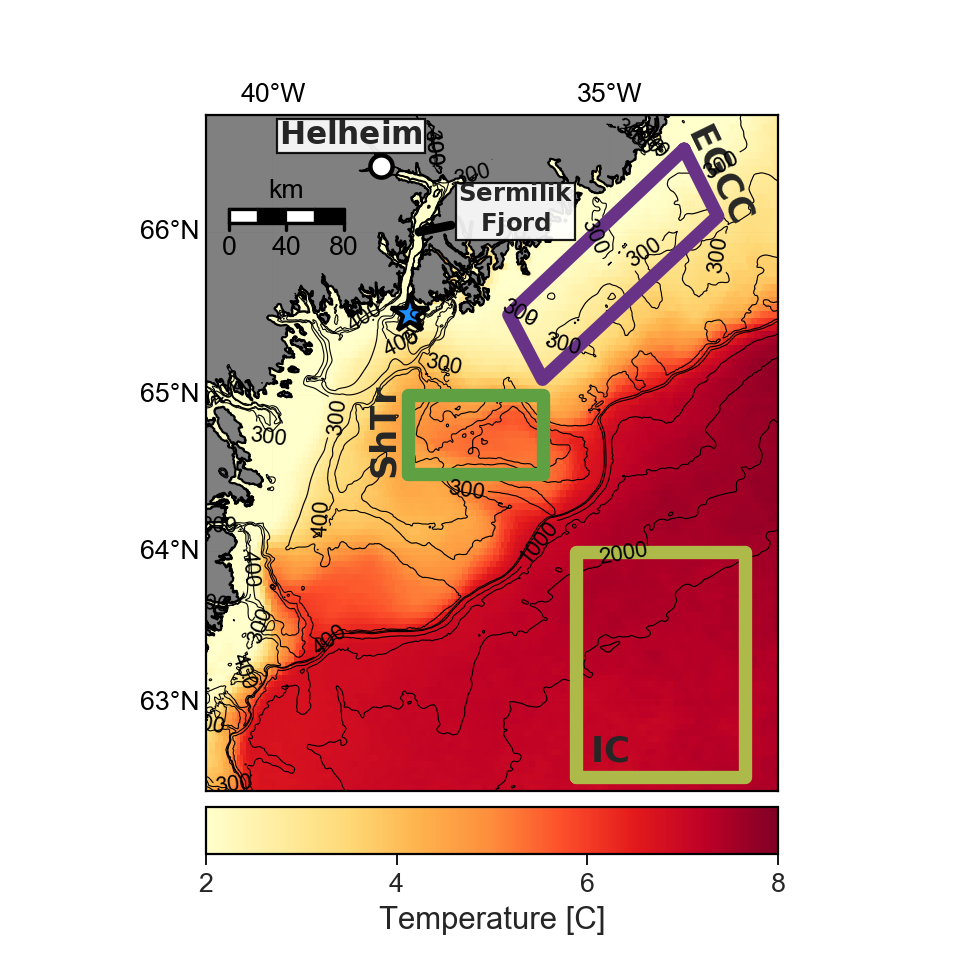

In [25]:
# Climatology map with sampling boxes (manuscript)
fig,ax = plt.subplots(figsize=(6, 6))
m = Basemap(projection='merc',llcrnrlat=llcrnrlatA,urcrnrlat=urcrnrlatA,llcrnrlon=llcrnrlonA,urcrnrlon=urcrnrlonA,lat_ts=65,resolution='h')

x, y = m(x_A,y_A)
m.drawcoastlines()
m.fillcontinents(color='gray',zorder=1)
m.drawparallels(np.arange(-80.,81.,1.),labels=[True,False,True,False],linewidth=0.01,fontsize=12)
m.drawmeridians(np.arange(-180.,181.,5.),labels=[False,False,True,False],linewidth=0.01,fontsize=12)
m.drawmapboundary(fill_color='white')
m.drawmapscale(-39.8,66.1,-38,65,80,barstyle='fancy',fontsize=12)
data = m.pcolor(x,y,meanAAnSST,cmap='YlOrRd',vmax=8.0,vmin=2.0) 

# Plot bathymetry contours
xb, yb = m(x_b,y_b)
cs = m.contour(xb,yb,bathy,[-4000,-3500,-3000,-2500,-2000,-1500,-1000,-500,-400,-300],colors='k',linewidths=0.5)

fmt = {}
strs = ['4000','3500','3000','2500','2000','1500','1000','500','400','300']
for l,s in zip(cs.levels,strs):
    fmt[l] = s
plt.clabel(cs, cs.levels[[0,2,4,6,8,9]],inline=True, fmt=fmt, fontsize=10, colors='k',zorder=-1)

# Plot boxes
i=0
for coord in boxes:
    x1,y1 = m(coord[2],coord[0])
    x2,y2 = m(coord[3],coord[0])
    x3,y3 = m(coord[3],coord[1])
    x4,y4 = m(coord[2],coord[1])
    x,y = zip((x1,y1),(x2,y2),(x3,y3),(x4,y4),(x1,y1))
    m.plot(x,y,color='C'+co[i],linewidth=6.0,zorder=2)
    i+=1
    
x1,y1 = m(EGCm_coords[0][0],EGCm_coords[0][1])
x2,y2 = m(EGCm_coords[1][0],EGCm_coords[1][1])
x3,y3 = m(EGCm_coords[2][0],EGCm_coords[2][1])
x4,y4 = m(EGCm_coords[3][0],EGCm_coords[3][1])
x,y = zip((x1,y1),(x2,y2),(x3,y3),(x4,y4),(x1,y1))
m.plot(x,y,color='C4',linewidth=6.0,zorder=2)

# Add labels and markers
plt.annotate('$\\bf{EGCC}$',m(-33.93,66.53),fontsize=16,rotation=296,zorder=2) # xytext=(0.8,0.8),textcoords='axes fraction',bbox=dict(fc='white', alpha=0.4,boxstyle='round,pad=0.04')
plt.annotate('$\\bf{ShTr}$',m(-38.55,64.9),fontsize=16,rotation=90,zorder=2) 
plt.annotate('$\\bf{IC}$',m(-35.3,62.6),fontsize=16,rotation=0,zorder=2) 
plt.annotate('$\\bf{Helheim}$',m(-39.91,66.53),fontsize=14,rotation=0,zorder=2, 
             bbox=dict(fc='white',ec='k',alpha=0.9,boxstyle='square,pad=0.08')) 
plt.annotate('$\\bf{Sermilik}$\n$\\bf{  Fjord}$',xy=m(-37.9,66.00),xytext=m(-36.4,66.0),fontsize=11,rotation=0,ha='center',zorder=2,
             arrowprops=dict(arrowstyle='-',ec='k',linewidth=4),
             bbox=dict(fc='white',ec='k',alpha=0.9,boxstyle='square,pad=0.08'))

mx,my = m(-37.9669,65.5028)
m.plot(mx,my,linestyle='none', marker='*', markersize=18, c='dodgerblue', markeredgecolor="black", markeredgewidth=2,zorder=3)
mx,my = m(-38.4,66.4)
m.plot(mx,my,linestyle='none', marker='o', markersize=10, c='white', markeredgecolor="black", markeredgewidth=2,zorder=3)

# Colorbar your face off
az = plt.gca()
divider = make_axes_locatable(az)
cax = divider.append_axes('bottom',size="7%",pad=0.1)
cb = colorbar(data,ticks=[2, 4, 6, 8],cax=cax,orientation='horizontal')
cb.ax.set_yticklabels(cb.ax.get_yticklabels())
cb.outline.set_edgecolor('k')
cb.outline.set_linewidth(1)
cb.ax.tick_params(color='k',size=5,labelsize=12)
cb.set_label('Temperature [C]',fontsize=14,rotation=0,labelpad=4)

plt.savefig('/Users/tsnow03/GoogleDrive/User/Docs/PhD_Project/MODIS_Manuscript/Figures/ClimatologyTnSST.jpg', format='jpg', dpi=800)

plt.show()

# Sensitivity analysis map

In [34]:
# Defining Lat/lon bounds
llcrnrlatA=63.4;urcrnrlatA=66.5;llcrnrlonA=-41.;urcrnrlonA=-34 # Entire Serm Shelf

latboundsb = [ 62.4 , 66.7 ] # Serm Shelf only
lonboundsb = [ -41 , -32.5 ]

In [47]:
# Shelf box test
latbounds11 = [ 64.5 , 65.00 ]
lonbounds11 = [ -38.0 , -36.0 ]
latbounds2 = [ 64.00 , 65.00 ] # Shelf
lonbounds2 = [ -38.40 , -36.40 ] 
latbounds3 = [ 64.5 , 65.00 ] # Shelf
lonbounds3 = [ -38.40 , -36.40 ] 
latbounds4 = [ 64.5 , 65.00 ] # Shelf
lonbounds4 = [ -38.40 , -36.0 ] 
latbounds5 = [ 64.5 , 65.00 ] # Shelf
lonbounds5 = [ -38.40 , -37.4 ] 

# Concatenate bounds for plotting
boxesShT = []
boxesShT.append(np.concatenate([latbounds2,lonbounds2]))
boxesShT.append(np.concatenate([latbounds3,lonbounds3]))
boxesShT.append(np.concatenate([latbounds4,lonbounds4]))
boxesShT.append(np.concatenate([latbounds5,lonbounds5]))
# boxesShT.append(np.concatenate([latbounds6,lonbounds6]))

ShT = np.concatenate([latbounds11,lonbounds11])

In [59]:
# Colors for plotting
co = ['4','1','7','6']

<IPython.core.display.Javascript object>


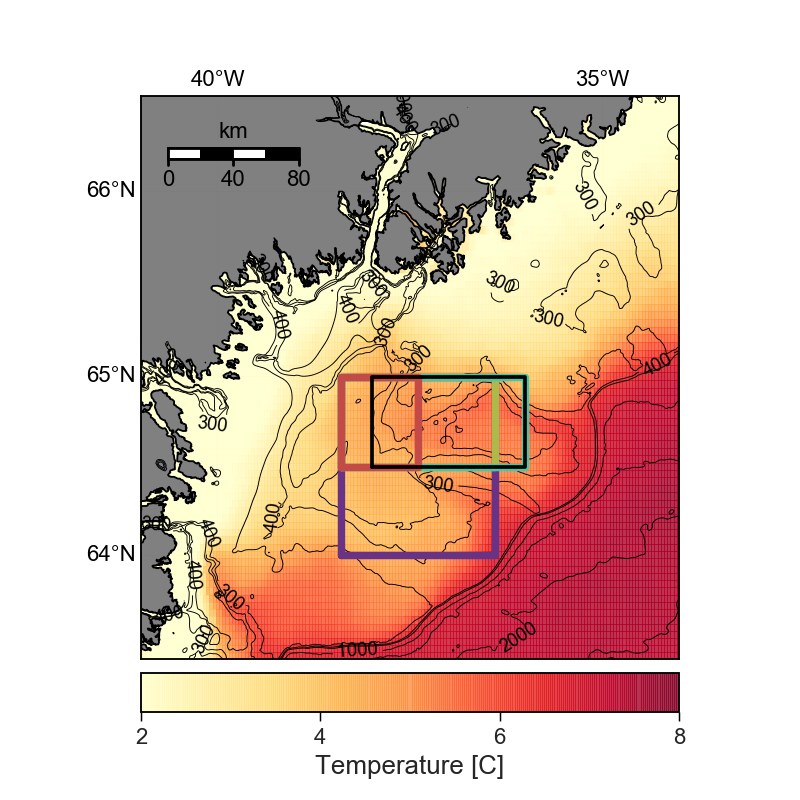

In [60]:
# Climatology map with shelf boxes from sensitivity test
fig,ax = plt.subplots(figsize=(6, 6))
m = Basemap(projection='merc',llcrnrlat=llcrnrlatA,urcrnrlat=urcrnrlatA,llcrnrlon=llcrnrlonA,urcrnrlon=urcrnrlonA,lat_ts=65,resolution='h')

x, y = m(x_A,y_A)
m.drawcoastlines()
m.fillcontinents(color='gray',zorder=1)
m.drawparallels(np.arange(-80.,81.,1.),labels=[True,False,True,False],linewidth=0.01,fontsize=12)
m.drawmeridians(np.arange(-180.,181.,5.),labels=[False,False,True,False],linewidth=0.01,fontsize=12)
m.drawmapboundary(fill_color='white')
m.drawmapscale(-39.8,66.2,-38,66.5,80,barstyle='fancy',fontsize=12)
data = m.pcolor(x,y,meanAAnSST,cmap='YlOrRd',vmax=8.0,vmin=2.0,alpha=0.8)

# Plot bathymetry contours
xb, yb = m(x_b,y_b)
cs = m.contour(xb,yb,bathy,[-4000,-3500,-3000,-2500,-2000,-1500,-1000,-500,-400,-300],colors='k',linewidths=0.5)

fmt = {}
strs = ['4000','3500','3000','2500','2000','1500','1000','500','400','300']
for l,s in zip(cs.levels,strs):
    fmt[l] = s
plt.clabel(cs, cs.levels[[0,2,4,6,8,9]],inline=True, fmt=fmt, fontsize=10, colors='k',zorder=-1)

# Plot boxes
i=0
for coord in boxesShT:
    x1,y1 = m(coord[2],coord[0])
    x2,y2 = m(coord[3],coord[0])
    x3,y3 = m(coord[3],coord[1])
    x4,y4 = m(coord[2],coord[1])
    x,y = zip((x1,y1),(x2,y2),(x3,y3),(x4,y4),(x1,y1))
    box_color = 'C'+co[i]
    m.plot(x,y,color=box_color,linewidth=4.0)
    i+=1

x1,y1 = m(ShT[2],ShT[0])
x2,y2 = m(ShT[3],ShT[0])
x3,y3 = m(ShT[3],ShT[1])
x4,y4 = m(ShT[2],ShT[1])
x,y = zip((x1,y1),(x2,y2),(x3,y3),(x4,y4),(x1,y1))
box_color = 'k'
m.plot(x,y,color=box_color,linewidth=2.0)

# Colorbar your face off
az = plt.gca()
divider = make_axes_locatable(az)
cax = divider.append_axes('bottom',size="7%",pad=0.1)
cb = colorbar(data,ticks=[2, 4, 6, 8],cax=cax,orientation='horizontal')
cb.ax.set_yticklabels(cb.ax.get_yticklabels())
cb.outline.set_edgecolor('k')
cb.outline.set_linewidth(1)
cb.ax.tick_params(color='k',size=5,labelsize=12)
cb.set_label('Temperature [C]',fontsize=14,rotation=0,labelpad=4)

plt.savefig('/Users/tsnow03/GoogleDrive/User/Docs/PhD_Project/MODIS_Manuscript/Figures/ShTrSensAnalysisMap.jpg', format='jpg', dpi=800)
plt.show()

# Figure 6

In [38]:
cd '/Volumes/Colossus/SST_Helheim_images/HelheimMODIS/GlobalAnnualSSTTerraNight'

/Volumes/Colossus/SST_Helheim_images/HelheimMODIS/GlobalAnnualSSTTerraNight


In [39]:
bdir = '/Volumes/Colossus/SST_Helheim_images/HelheimMODIS/GlobalAnnualSSTTerraNight'
years = ['2000','2001','2002','2003','2004','2005','2006','2007','2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018'] 

In [40]:
# Setup directories, create initial subsets
ref = os.listdir(bdir)[1]
fhref = Dataset(ref, mode='r')  
lonsb = fhref.variables['lon'][:]
latsb = fhref.variables['lat'][:]
lat_indsb = np.where((latsb > latboundsA[0]) & (latsb < latboundsA[1]))
lon_indsb = np.where((lonsb > lonboundsA[0]) & (lonsb < lonboundsA[1]))
lats_sub = latsb[lat_indsb[0]] # subsetting lat lon so can sample later
lons_sub = lonsb[lon_indsb[0]] # subsetting lat lon so can sample later
lons,lats = np.meshgrid(lons_sub,lats_sub)
indsI = np.where((lats > latboundsI[0]) & (lats < latboundsI[1]) & (lons > lonboundsI[0]) & (lons < lonboundsI[1]))

In [41]:
# SST climatology (interannual mean)
# Collect all annual SST rasters for specified area and average across them

try:
    del sst_arrayA
except:
    print ("no old variable to delete")

MODfilesA = [f for f in os.listdir(bdir)] 
for img in MODfilesA: 
    fhA = Dataset(img, mode='r')  
    sstA = fhA.variables['sst'][lat_indsb[0],lon_indsb[0]]
    sstAqa = fhA.variables['qual_sst'][lat_indsb[0],lon_indsb[0]]
    sstA = np.where(sstA<-2,np.nan,sstA)
    sstA = np.where(sstA>30,np.nan,sstA)
    sstA = np.where(sstAqa>=2,np.nan,sstA)
    
    # Irminger samples
    sstshelfI = sstA[indsI[0],indsI[1]]
    meanICsst = np.nanmean(sstshelfI)
    
    sstanom = sstA - meanICsst

    try:
        sst_arrayA = np.dstack((sst_arrayA, sstanom))
    except:
        sst_arrayA = sstanom

    fhA.close()
    print (img[1:5])
    
#Calculate mean and variability
meanAAnSST = np.nanmean(sst_arrayA, axis=2)
meanAAnSST = ma.masked_where(np.isnan(meanAAnSST),meanAAnSST) # masks all no data
errAAnSST = stats.sem(sst_arrayA, axis=2,nan_policy = 'omit')
errAAnSST = ma.masked_where(np.isnan(meanAAnSST),errAAnSST)
countAAnSST = np.count_nonzero(~np.isnan(sst_arrayA), axis=2)
countAAnSST = ma.masked_where(countAAnSST==0,countAAnSST)

# Create lat lon matrix for sst plotting
y_A = repeat(np.array(latsb[:].ravel())[lat_indsb],len(lon_indsb[0]),axis=0)
y_A = reshape(y_A,(len(lat_indsb[0]),len(lon_indsb[0])))
x_A = repeat(np.array(lonsb[:].ravel())[lon_indsb],len(lat_indsb[0]),axis=0)
x_A = reshape(x_A,(len(lon_indsb[0]),len(lat_indsb[0]))).T

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app


2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016


/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice


In [36]:
# Boxes for transect of small boxes across shelf
latbounds01 = [ 65.270 , 65.400 ] # Near mouth
lonbounds01 = [ -37.920 , -37.620 ] 
latbounds2 = [ 65.140 , 65.270 ] 
lonbounds2 = [ -37.888 , -37.588 ] 
latbounds3 = [ 65.010 , 65.140 ]
lonbounds3 = [ -37.846 , -37.546 ] 
latbounds4 = [ 64.880 , 65.010 ] 
lonbounds4 = [ -37.774 , -37.474 ] 
latbounds5 = [ 64.750 , 64.880 ] 
lonbounds5 = [ -37.804 , -37.504 ] 
latbounds6 = [ 64.680 , 64.810 ] 
lonbounds6 = [ -37.500 , -37.200 ] 
latbounds7 = [ 64.680 , 64.810 ] 
lonbounds7 = [ -37.200 , -36.900 ] 
latbounds8 = [ 64.710 , 64.840 ] 
lonbounds8 = [ -36.900 , -36.600 ] 
latbounds9 = [ 64.730 , 64.860 ] # [ 64.770 , 64.900 ]
lonbounds9 = [ -36.600 , -36.300 ] 
latbounds10 = [ 64.680 , 64.810 ] #[ 64.730 , 64.860 ] 
lonbounds10 = [ -36.300 , -36.000 ] 
latbounds11 = [ 64.650 , 64.780 ]  #[ 64.690 , 64.820 ] 
lonbounds11 = [ -36.000 , -35.700 ] 
latbounds12 = [ 64.630 , 64.760 ] 
lonbounds12 = [ -35.700 , -35.400 ] 
latbounds13 = [ 64.610 , 64.740 ] #Outter trough
lonbounds13 = [ -35.400 , -35.100 ] 

boxes = []
boxes.append(np.concatenate([latbounds01,lonbounds01]))
boxes.append(np.concatenate([latbounds2,lonbounds2]))
boxes.append(np.concatenate([latbounds3,lonbounds3]))
boxes.append(np.concatenate([latbounds4,lonbounds4]))
boxes.append(np.concatenate([latbounds5,lonbounds5]))
boxes.append(np.concatenate([latbounds6,lonbounds6]))
boxes.append(np.concatenate([latbounds7,lonbounds7]))
boxes.append(np.concatenate([latbounds8,lonbounds8]))
boxes.append(np.concatenate([latbounds9,lonbounds9]))
boxes.append(np.concatenate([latbounds10,lonbounds10]))
boxes.append(np.concatenate([latbounds11,lonbounds11]))
boxes.append(np.concatenate([latbounds12,lonbounds12]))
boxes.append(np.concatenate([latbounds13,lonbounds13]))
boxes.append(np.concatenate([latboundsI,lonboundsI]))

<IPython.core.display.Javascript object>


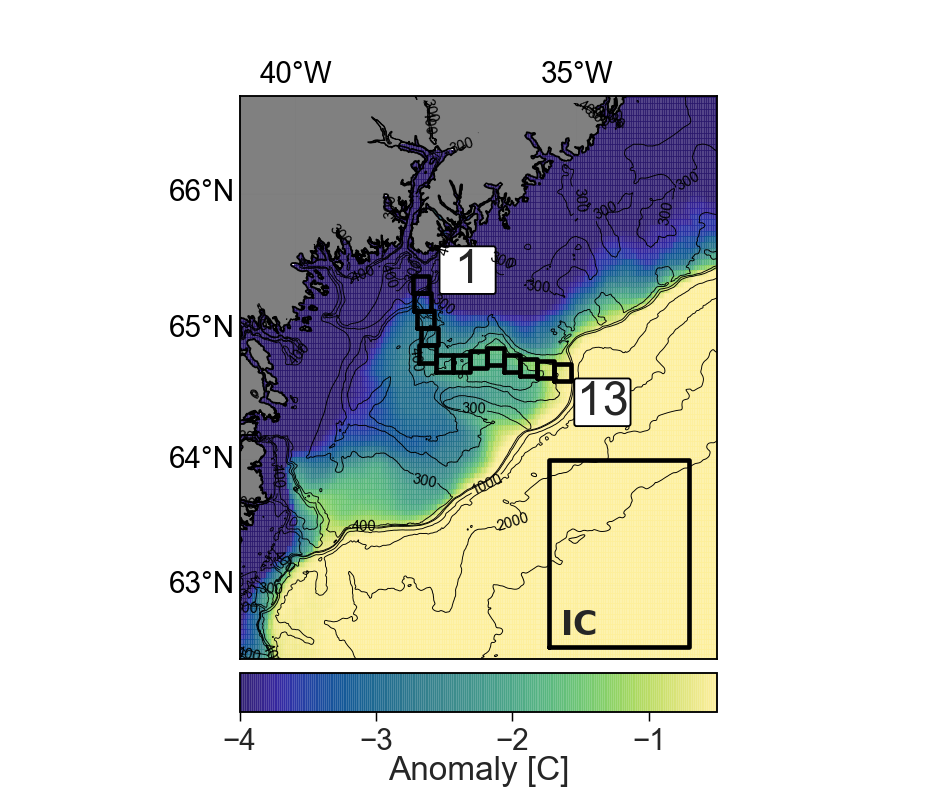

In [48]:
# For horizontal colorbar
fig,ax17 = plt.subplots(figsize=(7, 6))
m = Basemap(projection='merc',llcrnrlat=llcrnrlatA,urcrnrlat=urcrnrlatA,llcrnrlon=llcrnrlonA,urcrnrlon=urcrnrlonA,lat_ts=65,resolution='h')

x, y = m(x_A,y_A)
m.drawcoastlines()
m.fillcontinents(color='gray',zorder=1)
m.drawparallels(np.arange(-80.,81.,1.),labels=[True,False,True,False],linewidth=0.01,fontsize=16)
m.drawmeridians(np.arange(-180.,181.,5.),labels=[False,False,True,False],linewidth=0.01,fontsize=16)
m.drawmapboundary(fill_color='white')
data = m.pcolor(x,y,meanAAnSST,cmap=cmocean.cm.haline,alpha=0.8,vmax=-0.5,vmin=-4.0) #vmax=12 for Irm, 10 for shelf
# nm = 'Mean MODIS SST 2000-2017'
# title(nm)
# colorbar()

# Plot bathymetry contours
xb, yb = m(x_b,y_b)
cs = m.contour(xb,yb,bathy,[-4000,-3500,-3000,-2500,-2000,-1500,-1000,-500,-400,-300],colors='k',linewidths=0.5)

fmt = {}
# strs = ['4000','3500','3000','2500','2000','1500','1000','400','300']
strs = ['4000','3500','3000','2500','2000','1500','1000','500','400','300']
for l,s in zip(cs.levels,strs):
    fmt[l] = s
# plt.clabel(cs, cs.levels[[0,2,4,6,7,8]],inline=True, fmt=fmt, fontsize=8, colors='k')
plt.clabel(cs, cs.levels[[0,2,4,6,8,9]],inline=True, fmt=fmt, fontsize=8, colors='k')

# # Plot line
# x1,y1 = m(-38.2,64.4)
# x2,y2 = m(-36.9,65.1)
# plt.plot((x1,x2),(y1,y2),'w',ls='dashed',linewidth=5)

for coord in boxes:
    x1,y1 = m(coord[2],coord[0])
    x2,y2 = m(coord[3],coord[0])
    x3,y3 = m(coord[3],coord[1])
    x4,y4 = m(coord[2],coord[1])
    x,y = zip((x1,y1),(x2,y2),(x3,y3),(x4,y4),(x1,y1))
    m.plot(x,y,color='k',linewidth=2.5)
    
plt.annotate(' 1 ',m(-37.4,65.35),fontsize=25,zorder=2,bbox=dict(fc='white',ec='k',boxstyle='round,pad=0.05')) 
plt.annotate('13',m(-35.0,64.35),fontsize=25,zorder=2,bbox=dict(fc='white',ec='k',boxstyle='round,pad=0.05'))
plt.annotate('$\\bf{IC}$',m(-35.3,62.6),fontsize=18,rotation=0,zorder=2)
# plt.annotate('$\\bf{InS}$',xy=m(-38.2,65.2),xytext=m(-38.8,64.67),color='w',fontsize=18,rotation=50,zorder=2,arrowprops=dict(arrowstyle='->',color='w',lw=2))

# Colorbar your face off
az = plt.gca()
divider = make_axes_locatable(az)
cax = divider.append_axes('bottom',size="7%",pad=0.1)
cb = colorbar(data,ticks=[-4,-3,-1,-2,0],orientation='horizontal',cax=cax)
cb.ax.set_yticklabels(cb.ax.get_yticklabels(),fontsize=16)
cb.outline.set_edgecolor('k')
cb.outline.set_linewidth(1)
cb.ax.tick_params(color='k',size=5,labelsize=16)
cb.set_label('Anomaly [C]', fontsize=18, labelpad=0)

plt.savefig('/Users/tsnow03/GoogleDrive/User/Docs/PhD_Project/Conferences/AGU_2019/Figures/Anom_bar.jpg', format='jpg', dpi=1000)

plt.show()

# Good daily time series code

In [32]:
# Some years don't have multiple months recorded for a season so need to run them separately
yearT = ['2000','2001','2002','2003','2004','2005','2006','2007','2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018'] 
yearA = ['2002','2003','2004','2005','2006','2007','2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018']

In [33]:
latboundsb = [ 62.4 , 66.7 ] # Serm Shelf only
lonboundsb = [ -41 , -32.5 ]

In [34]:
# Simple boundary boxes for IC, EGCC, and shelf
latboundsI = [ 62.5 , 64.0 ]
lonboundsI = [ -35.5 , -33.0 ]
EGCm_coords = [[-33.9,66.5],[-33.4,66.1],[-36.0,65.1],[-36.5,65.5]] # for box diagonal to grid
latboundsshelf = [ 64.5 , 65.00 ]
lonboundsshelf = [ -38.0 , -36.0 ]

In [35]:
# Directories and files for each product Terra Day & Night, Aqua Day & Night
# sat = 'Terra'
sat = 'Aqua'
# prod = ''
prod = 'Night'

bdir = '/Volumes/Colossus/SST_Helheim_images/HelheimMODIS/GlobalSST'+sat+prod
icedir = '/Volumes/LaCieGrande/MODIS_SeaIce_Helheim/GlobalSeaIce'+sat+'/Aligned'

# Get list of sea ice files
os.chdir(icedir)
MOD29filelist = Snow.get_file_in_directory(icedir)
os.chdir(bdir)
print (sat+prod)

AquaNight


In [36]:
# Get lats and lons and spatial sampling box indices here because same for every image
ref = os.listdir(bdir)[1]
fhref = Dataset(ref, mode='r')  
lonsb = fhref.variables['lon'][:]
latsb = fhref.variables['lat'][:]
lat_indsb = np.where((latsb > latboundsb[0]) & (latsb < latboundsb[1]))
lon_indsb = np.where((lonsb > lonboundsb[0]) & (lonsb < lonboundsb[1]))
lats_sub = latsb[lat_indsb[0]] # subsetting lat lon so can sample later
lons_sub = lonsb[lon_indsb[0]] # subsetting lat lon so can sample later
lons,lats = np.meshgrid(lons_sub,lats_sub)
indsI = np.where((lats > latboundsI[0]) & (lats < latboundsI[1]) & (lons > lonboundsI[0]) & (lons < lonboundsI[1]))
inds2 = np.where((lats > latboundsshelf[0]) & (lats < latboundsshelf[1]) & (lons > lonboundsshelf[0]) & (lons < lonboundsshelf[1]))
inds1 = np.where((lats > latbounds1[0]) & (lats < latbounds1[1]) & (lons > lonbounds1[0]) & (lons < lonbounds1[1]))

# For diagonal EGCC box
EGCmask_coords = regionmask.Regions_cls('EGCmask',[0],['EGCC'],['E'],[EGCm_coords])
EGCCbox = EGCmask_coords.mask(lons_sub,lats_sub,xarray=False)

In [51]:
# Build daily mean and max time series, absolute and anomaly 
sstshelfmn = []
sstshelfanommn = []
varshelfmn = []
# stdshelfmn = []
sstshelfZ4mn = []
sstshelfZ4anommn = []
varshelfZ4mn = []
stdshelfZ4mn = []
sstshelfmax = []
sstshelfanommax = []
sstshelfallmn = []
sstshelfallanommn = []
varshelfallmn = []
stdshelfallmn = []
sstIC = []
varIC = []
stdIC = []
sstEGC = []
sstEGCanom = []
varEGC = []
stdEGC = []

pix = []
pixI = []
pixE = []
date = []

for year in yearT:
    # To make monthly means for all years
    start = datetime.datetime(int(year),01,01)
    end = datetime.datetime(int(year),12,31)
    e = 0
    while start < end:
        print (year)
        months = calendar.monthrange(start.year,start.month)
        e += months[1]
        month = start.strftime("%B")
        first = e-months[1]+1
        last = e
        print (month, first, last)
        start += datetime.timedelta(days=months[1])
        
        if sat+prod=='Aqua':
            # For Aqua
            MODfilesb = [f for f in os.listdir(bdir) if (year in f[1:5]) & (first <= int(f[5:8])) & (last+1 >= int(f[5:8]))] # to bin across months
        else: 
            # For Terra, Tn, An
            MODfilesb = [f for f in os.listdir(bdir) if (year in f[1:5]) & (first < int(f[5:8])) & (last+1 >= int(f[5:8]))] # to bin across months
        
        for img in MODfilesb:
            fhb = Dataset(img, mode='r')              
            sstb = fhb.variables['sst'][lat_indsb[0],lon_indsb[0]]
            sstbqa = fhb.variables['qual_sst'][lat_indsb[0],lon_indsb[0]]
            sstb = np.where(sstb<-2,np.nan,sstb)
            sstb = np.where(sstb>30,np.nan,sstb)
            sstb = np.where(sstbqa>=2,np.nan,sstb) #keep only pixels that have best qa of 0 or 1
            
            icedate = img[1:8]
            try:
                MOD29file = [f for f in MOD29filelist if f[10:17]==icedate]
                icefile = icedir +'/'+ MOD29file[0]
                icemask = np.load(icefile)
                sstb = np.where(icemask==1,sstb,np.nan)
            except Exception as err: 
                print (err)
                print ("No MOD29 file match found for", img)
            
            # Irminger samples
            sstshelfI = sstb[indsI[0],indsI[1]]
            meanICsst = np.nanmean(sstshelfI)
            
            # EGCC sample
#             sstshelfE = sstb[indsE[0],indsE[1]] # for box parallel to grid
            sstshelfE = ma.masked_where(np.isnan(EGCCbox),sstb) # for box diagonal to grid
            sstshelfE = sstshelfE[sstshelfE.mask==False]
            sstshelfanomE = sstshelfE - meanICsst
            
            # Shelf sample
            sstshelf = sstb[inds2[0],inds2[1]]
            sstshelfanom = sstshelf - meanICsst
            
            # Z4 sample
            sstshelf1 = sstb[inds1[0],inds1[0]]
            sstshelfanom1 = sstshelf1 - meanICsst
            
            # Mean of 10 warmest pixels in Shelf sample
            if (np.isfinite(sstshelf)).sum() > 10:
                sstnonnan = sstshelf.ravel()[np.isfinite(sstshelf.ravel())]
                sstanomnonnan = sstshelfanom.ravel()[np.isfinite(sstshelfanom.ravel())]
                sstshelfmn.append(np.nanmean(sstnonnan[sstnonnan.argsort()[-10:]]))
                sstshelfanommn.append(np.nanmean(sstanomnonnan[sstanomnonnan.argsort()[-10:]]))
                varshelfmn.append(stats.sem(sstnonnan[sstnonnan.argsort()[-10:]], axis=None, nan_policy = 'omit'))
            else:
                sstshelfmn.append(np.nan)
                sstshelfanommn.append(np.nan)
                varshelfmn.append(np.nan)
            
            # Mean of shelf box
            sstshelfallmn.append(np.nanmean(sstshelf))
            sstshelfallanommn.append(np.nanmean(sstshelfanom))
            varshelfallmn.append(stats.sem(sstshelf, axis=None, nan_policy = 'omit'))
            stdshelfallmn.append(np.nanstd(sstshelf))
            
            # Mean of Z4 box
            sstshelfZ4mn.append(np.nanmean(sstshelf1))
            sstshelfZ4anommn.append(np.nanmean(sstshelfanom1))
            varshelfZ4mn.append(stats.sem(sstshelf1, axis=None, nan_policy = 'omit'))
            stdshelfZ4mn.append(np.nanstd(sstshelf1))

            # Max of Shelf sample
            if np.nanmax(sstshelf)==np.nan:
                sstshelfmax.append(np.nan)
                sstshelfanommax.append(np.nan)
            else:
                sstshelfmax.append(np.nanmax(sstshelf))
                sstshelfanommax.append(np.nanmax(sstshelfanom))
            
            # Mean, stderr and std of IC box
            sstIC.append(meanICsst)
            varIC.append(stats.sem(sstshelfI, axis=None, nan_policy = 'omit'))
            stdIC.append(np.nanstd(sstshelfI))

            # Mean, stderr and std of EGCC box
            sstEGC.append(np.nanmean(sstshelfE))
            print(np.nanmean(sstshelfE))
            sstEGCanom.append(np.nanmean(sstshelfanomE))
            varEGC.append(stats.sem(sstshelfE, axis=None, nan_policy = 'omit'))
            stdEGC.append(np.nanstd(sstshelfE))
            
            # Count number of pixels per measurements
            pix.append((np.isfinite(sstshelf)).sum())
            pixI.append((np.isfinite(sstshelfI)).sum())
            pixE.append((np.isfinite(sstshelfE)).sum())
    
            date.append(fhb.time_coverage_start[0:10])
            print (img, "completed with",(np.isfinite(sstshelf)).sum(),"pixels")
            
            fhb.close()

2000
January 1 31
2000
February 32 60
nan
T2000056.L3m_DAY_NSST_sst_4km.nc completed with 12 pixels
nan
T2000057.L3m_DAY_NSST_sst_4km.nc completed with 0 pixels
nan
T2000058.L3m_DAY_NSST_sst_4km.nc completed with 0 pixels
0.69055545
T2000059.L3m_DAY_NSST_sst_4km.nc completed with 369 pixels
nan
T2000060.L3m_DAY_NSST_sst_4km.nc completed with 0 pixels
nan
T2000061.L3m_DAY_NSST_sst_4km.nc completed with 0 pixels
2000
March 61 91
nan
T2000062.L3m_DAY_NSST_sst_4km.nc completed with 0 pixels


/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:106: RuntimeWarning: Mean of empty slice
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:107: RuntimeWarning: Mean of empty slice
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:125: RuntimeWarning: Mean of empty slice
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:126: RuntimeWarning: Mean of empty slice
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:127: RuntimeWarning: Mean of empty slice
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: Mean of empty slice
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: Mean of empty slice
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:112: RuntimeWarning: All-NaN slice encountered
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py

nan
T2000063.L3m_DAY_NSST_sst_4km.nc completed with 0 pixels
nan
T2000064.L3m_DAY_NSST_sst_4km.nc completed with 0 pixels
nan
T2000065.L3m_DAY_NSST_sst_4km.nc completed with 242 pixels
nan
T2000066.L3m_DAY_NSST_sst_4km.nc completed with 236 pixels
nan
T2000067.L3m_DAY_NSST_sst_4km.nc completed with 0 pixels
nan
T2000068.L3m_DAY_NSST_sst_4km.nc completed with 0 pixels
nan
T2000069.L3m_DAY_NSST_sst_4km.nc completed with 0 pixels
nan
T2000070.L3m_DAY_NSST_sst_4km.nc completed with 79 pixels
nan
T2000071.L3m_DAY_NSST_sst_4km.nc completed with 0 pixels
nan
T2000072.L3m_DAY_NSST_sst_4km.nc completed with 0 pixels


/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: Mean of empty slice


nan
T2000073.L3m_DAY_NSST_sst_4km.nc completed with 31 pixels
nan
T2000074.L3m_DAY_NSST_sst_4km.nc completed with 0 pixels
nan
T2000075.L3m_DAY_NSST_sst_4km.nc completed with 0 pixels
nan
T2000076.L3m_DAY_NSST_sst_4km.nc completed with 0 pixels
nan
T2000077.L3m_DAY_NSST_sst_4km.nc completed with 145 pixels
nan
T2000078.L3m_DAY_NSST_sst_4km.nc completed with 0 pixels
nan
T2000079.L3m_DAY_NSST_sst_4km.nc completed with 0 pixels
nan
T2000080.L3m_DAY_NSST_sst_4km.nc completed with 107 pixels
nan
T2000081.L3m_DAY_NSST_sst_4km.nc completed with 100 pixels
nan
T2000082.L3m_DAY_NSST_sst_4km.nc completed with 0 pixels
nan
T2000083.L3m_DAY_NSST_sst_4km.nc completed with 1 pixels
nan
T2000084.L3m_DAY_NSST_sst_4km.nc completed with 296 pixels
nan
T2000085.L3m_DAY_NSST_sst_4km.nc completed with 0 pixels
nan
T2000086.L3m_DAY_NSST_sst_4km.nc completed with 0 pixels
nan
T2000087.L3m_DAY_NSST_sst_4km.nc completed with 0 pixels
nan
T2000088.L3m_DAY_NSST_sst_4km.nc completed with 0 pixels
nan
T2000089.L3

nan
T2000209.L3m_DAY_NSST_sst_4km.nc completed with 109 pixels
nan
T2000210.L3m_DAY_NSST_sst_4km.nc completed with 0 pixels
nan
T2000211.L3m_DAY_NSST_sst_4km.nc completed with 120 pixels
nan
T2000212.L3m_DAY_NSST_sst_4km.nc completed with 0 pixels
nan
T2000213.L3m_DAY_NSST_sst_4km.nc completed with 15 pixels
nan
T2000214.L3m_DAY_NSST_sst_4km.nc completed with 0 pixels
2000
August 214 244
nan
T2000215.L3m_DAY_NSST_sst_4km.nc completed with 0 pixels
nan
T2000216.L3m_DAY_NSST_sst_4km.nc completed with 0 pixels
2.482143
T2000217.L3m_DAY_NSST_sst_4km.nc completed with 192 pixels
1.8426607
T2000218.L3m_DAY_NSST_sst_4km.nc completed with 255 pixels
list index out of range
('No MOD29 file match found for', 'T2000219.L3m_DAY_NSST_sst_4km.nc')
nan
T2000219.L3m_DAY_NSST_sst_4km.nc completed with 0 pixels
nan
T2000232.L3m_DAY_NSST_sst_4km.nc completed with 0 pixels
nan
T2000233.L3m_DAY_NSST_sst_4km.nc completed with 0 pixels
nan
T2000234.L3m_DAY_NSST_sst_4km.nc completed with 0 pixels
3.05
T200023

KeyboardInterrupt: 

In [318]:
datafile = '/Volumes/Colossus/SST_Helheim_images/Results/'+sat+prod+'MODISsst4km_masked20200123.csv'

datatable = open(datafile, 'a')
writer = csv.writer(datatable, dialect = 'excel')
print ("opened")    
for i,j in enumerate(date):
    try:
        writer.writerow(  [str(date[i])]  +  [str(sstshelfmn[i])] + [str(sstshelfanommn[i])] + [str(varshelfmn[i])] +
                        [str(sstshelfmax[i])] + [str(sstshelfanommax[i])] + [str(sstshelfallmn[i])] + 
                        [str(sstshelfallanommn[i])] + [str(varshelfallmn[i])] + [str(stdshelfallmn[i])] +
                        [str(sstIC[i])] + [str(varIC[i])] + [str(stdIC[i])] + [str(sstEGC[i])] + [str(sstEGCanom[i])] + 
                        [str(varEGC[i])] + [str(stdEGC[i])] + [str(sstshelfZ4mn[i])] + [str(varshelfZ4mn[i])] + 
                        [str(stdshelfZ4mn[i])] + [str(sstshelfZ4anommn[i])] + [str(pix[i])] + 
                        [str(pixI[i])] + [str(pixE[i])] )
 
    except Exception as a:
        print (img)
        print (a)                      
datatable.close() 

opened


# Transect SSTs

In [292]:
# Boxes for transect of small boxes across shelf in trough
latbounds01 = [ 65.270 , 65.400 ] # Near mouth
lonbounds01 = [ -37.920 , -37.620 ] 
latbounds2 = [ 65.140 , 65.270 ] 
lonbounds2 = [ -37.888 , -37.588 ] 
latbounds3 = [ 65.010 , 65.140 ]
lonbounds3 = [ -37.846 , -37.546 ] 
latbounds4 = [ 64.880 , 65.010 ] 
lonbounds4 = [ -37.774 , -37.474 ] 
latbounds5 = [ 64.750 , 64.880 ] 
lonbounds5 = [ -37.804 , -37.504 ] 
latbounds6 = [ 64.680 , 64.810 ] 
lonbounds6 = [ -37.500 , -37.200 ] 
latbounds7 = [ 64.680 , 64.810 ] 
lonbounds7 = [ -37.200 , -36.900 ] 
latbounds8 = [ 64.710 , 64.840 ] 
lonbounds8 = [ -36.900 , -36.600 ] 
latbounds9 = [ 64.730 , 64.860 ] # [ 64.770 , 64.900 ]
lonbounds9 = [ -36.600 , -36.300 ] 
latbounds10 = [ 64.680 , 64.810 ] #[ 64.730 , 64.860 ] 
lonbounds10 = [ -36.300 , -36.000 ] 
latbounds11 = [ 64.650 , 64.780 ]  #[ 64.690 , 64.820 ] 
lonbounds11 = [ -36.000 , -35.700 ] 
latbounds12 = [ 64.630 , 64.760 ] 
lonbounds12 = [ -35.700 , -35.400 ] 
latbounds13 = [ 64.610 , 64.740 ] #Outer trough
lonbounds13 = [ -35.400 , -35.100 ] 

# # Boxes for transect of small boxes across shelf in EGCC
# latbounds01 = [ 65.400 , 65.530 ] # Near mouth
# lonbounds01 = [ -37.620 , -37.320 ] 
# latbounds2 = [ 65.270 , 65.400 ] 
# lonbounds2 = [ -37.588 , -37.288 ] 
# latbounds3 = [ 65.140 , 65.270 ]
# lonbounds3 = [ -37.500 , -37.200 ] 
# # latbounds4 = [ 65.010 , 65.140 ] 
# # lonbounds4 = [ -37.474 , -37.174 ] 
# latbounds5 = [ 65.050 , 65.180 ] 
# lonbounds5 = [ -37.200 , -36.900 ]  
# latbounds6 = [ 65.050 , 65.180 ]  
# lonbounds6 = [ -36.900 , -36.600 ]
# latbounds7 = [ 65.050 , 65.180 ]  
# lonbounds7 = [ -36.600 , -36.300 ]
# latbounds8 = [ 65.000 , 65.130 ]  
# lonbounds8 = [ -36.300 , -36.000 ] 
# latbounds9 = [ 64.950 , 65.080 ] 
# lonbounds9 =  [ -36.000 , -35.700 ] 
# latbounds10 = [ 64.890 , 65.020 ] 
# lonbounds10 = [ -35.700 , -35.400 ]
# latbounds11 = [ 64.780 , 64.910 ]  
# lonbounds11 = [ -35.400 , -35.100 ]
# latbounds12 = [ 64.760 , 64.890 ] 
# lonbounds12 = [ -35.100 , -34.800 ]
# # latbounds13 = [ 64.740 , 64.870 ] #Outer trough
# # lonbounds13 = [ -34.800 , -34.500 ] 

latboundsI = [ 62.5 , 64.0 ]
lonboundsI = [ -35.5 , -33.0 ]
EGCm_coords = [[-33.9,66.5],[-33.4,66.1],[-36.0,65.1],[-36.5,65.5]] # for box diagonal to grid

In [56]:
yearT = ['2000','2001','2002','2003','2004','2005','2006','2007','2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018'] 

In [73]:
sat = 'Aqua'
# sat = 'Terra'
# prod = ''
prod = 'Night'

bdir = '/Volumes/Colossus/SST_Helheim_images/HelheimMODIS/GlobalSST'+sat+prod
icedir = '/Volumes/LaCieGrande/MODIS_SeaIce_Helheim/GlobalSeaIce'+sat+'/Aligned'
os.chdir(icedir)
MOD29filelist = Snow.get_file_in_directory(icedir)
os.chdir(bdir)
print (sat+prod)

AquaNight


In [74]:
# Get lats and lons and spatial sampling box indices here because same for every image
ref = os.listdir(bdir)[1]
fhref = Dataset(ref, mode='r')  
lonsb = fhref.variables['lon'][:]
latsb = fhref.variables['lat'][:]
lat_indsb = np.where((latsb > latboundsb[0]) & (latsb < latboundsb[1]))
lon_indsb = np.where((lonsb > lonboundsb[0]) & (lonsb < lonboundsb[1]))
lats_sub = latsb[lat_indsb[0]] # subsetting lat lon so can sample later
lons_sub = lonsb[lon_indsb[0]] # subsetting lat lon so can sample later
lons,lats = np.meshgrid(lons_sub,lats_sub)
indsI = np.where((lats > latboundsI[0]) & (lats < latboundsI[1]) & (lons > lonboundsI[0]) & (lons < lonboundsI[1]))
inds01 = np.where((lats > latbounds01[0]) & (lats < latbounds01[1]) & (lons > lonbounds01[0]) & (lons < lonbounds01[1]))
inds2 = np.where((lats > latbounds2[0]) & (lats < latbounds2[1]) & (lons > lonbounds2[0]) & (lons < lonbounds2[1]))
inds3 = np.where((lats > latbounds3[0]) & (lats < latbounds3[1]) & (lons > lonbounds3[0]) & (lons < lonbounds3[1]))
inds4 = np.where((lats > latbounds4[0]) & (lats < latbounds4[1]) & (lons > lonbounds4[0]) & (lons < lonbounds4[1]))
inds5 = np.where((lats > latbounds5[0]) & (lats < latbounds5[1]) & (lons > lonbounds5[0]) & (lons < lonbounds5[1]))
inds6 = np.where((lats > latbounds6[0]) & (lats < latbounds6[1]) & (lons > lonbounds6[0]) & (lons < lonbounds6[1]))
inds7 = np.where((lats > latbounds7[0]) & (lats < latbounds7[1]) & (lons > lonbounds7[0]) & (lons < lonbounds7[1]))
inds8 = np.where((lats > latbounds8[0]) & (lats < latbounds8[1]) & (lons > lonbounds8[0]) & (lons < lonbounds8[1]))
inds9 = np.where((lats > latbounds9[0]) & (lats < latbounds9[1]) & (lons > lonbounds9[0]) & (lons < lonbounds9[1]))
inds10 = np.where((lats > latbounds10[0]) & (lats < latbounds10[1]) & (lons > lonbounds10[0]) & (lons < lonbounds10[1]))
inds11 = np.where((lats > latbounds11[0]) & (lats < latbounds11[1]) & (lons > lonbounds11[0]) & (lons < lonbounds11[1]))
inds12 = np.where((lats > latbounds12[0]) & (lats < latbounds12[1]) & (lons > lonbounds12[0]) & (lons < lonbounds12[1]))
inds13 = np.where((lats > latbounds13[0]) & (lats < latbounds13[1]) & (lons > lonbounds13[0]) & (lons < lonbounds13[1]))

# For diagonal EGCC box
EGCmask_coords = regionmask.Regions_cls('EGCmask',[0],['EGCC'],['E'],[EGCm_coords])
EGCCbox = EGCmask_coords.mask(lons_sub,lats_sub,xarray=False)

In [75]:
# Line sampling - Build daily mean time series (T, AN, TN different than Aqua code - dates are listed slightly differently)
# Comment out 4 and 13 for EGCC transect
meanSST01 = []
countSST01 = []
meanSST2 = []
countSST2 = []
meanSST3 = []
countSST3 = []
meanSST4 = []
countSST4 = []
meanSST5 = []
countSST5 = []
meanSST6 = []
countSST6 = []
meanSST7 = []
countSST7 = []
meanSST8 = []
countSST8 = []
meanSST9 = []
countSST9 = []
meanSST10 = []
countSST10 = []
meanSST11 = []
countSST11 = []
meanSST12 = []
countSST12 = []
meanSST13 = []
countSST13 = []
date = []

# Process in chunks by year and month
for year in yearT:
    start = datetime.datetime(int(year),01,01)
    end = datetime.datetime(int(year),12,31)
    e = 0
    while start < end:
        print (year)
        
        months = calendar.monthrange(start.year,start.month)
        e += months[1]
        month = start.strftime("%B")
        first = e-months[1]+1
        last = e
        print (month, first, last)
        start += datetime.timedelta(days=months[1])
        count = 1
        if sat+prod=='Aqua':
            # For Aqua
            MODfilesb = [f for f in os.listdir(bdir) if (year in f[1:5]) & (first <= int(f[5:8])) & (last+1 >= int(f[5:8]))] # to bin across months
        else: 
            # For Terra, Tn, An
            MODfilesb = [f for f in os.listdir(bdir) if (year in f[1:5]) & (first < int(f[5:8])) & (last+1 >= int(f[5:8]))] # to bin across months
 
        if MODfilesb!=[]:
            for img in MODfilesb:
                # Read in daily SSTs and QA
                fhb = Dataset(img, mode='r')              
                sstb = fhb.variables['sst'][lat_indsb[0],lon_indsb[0]]
                sstbqa = fhb.variables['qual_sst'][lat_indsb[0],lon_indsb[0]]
                sstb = np.where(sstb<-2,np.nan,sstb)
                sstb = np.where(sstb>30,np.nan,sstb)
                sstb = np.where(sstbqa>=2,np.nan,sstb) #keep only pixels that have qa of 0 or 1
                date.append(fhb.time_coverage_start[0:10])
                
                # Mask sea ice
                icedate = img[1:8]
                try:
                    MOD29file = [f for f in MOD29filelist if f[10:17]==icedate]
                    icefile = icedir +'/'+ MOD29file[0]
                    icemask = np.load(icefile)
                    sstb = np.where(icemask==1,sstb,np.nan)
                except:
                    print (("No MOD29 file match found for", img))
                
                # Extract samples using bounding boxes and average
                # Irminger samples
                sstshelfI = sstb[indsI[0],indsI[1]]
                meanICsst = np.nanmean(sstshelfI)
                
                # EGCC samples
                sstshelfE = ma.masked_where(np.isnan(EGCCbox),sstb)
                sstshelfE = sstshelfE[sstshelfE.mask==False]
                meanEgcsst = np.nanmean(sstshelfE)
                
                # Transect samples 1-13
                sstshelf01 = sstb[inds01[0],inds01[1]]

                sstshelf2 = sstb[inds2[0],inds2[1]]
                
                sstshelf3 = sstb[inds3[0],inds3[1]]
                
                # ***Comment out 4 for transect within EGCC
                sstshelf4 = sstb[inds4[0],inds4[1]]
                
                sstshelf5 = sstb[inds5[0],inds5[1]]
                
                sstshelf6 = sstb[inds6[0],inds6[1]]
                
                sstshelf7 = sstb[inds7[0],inds7[1]]
                
                sstshelf8 = sstb[inds8[0],inds8[1]]
                
                sstshelf9 = sstb[inds9[0],inds9[1]]
                
                sstshelf10 = sstb[inds10[0],inds10[1]]
                
                sstshelf11 = sstb[inds11[0],inds11[1]]
                
                sstshelf12 = sstb[inds12[0],inds12[1]]
                
                # Comment out 13 for transect within EGCC
                sstshelf13 = sstb[inds13[0],inds13[1]]
                
                fhb.close()
                
                # Append daily mean and count for timeseries
                meanSST01.append(np.nanmean(sstshelf01))
                meanSST2.append(np.nanmean(sstshelf2))
                meanSST3.append(np.nanmean(sstshelf3))
                meanSST4.append(np.nanmean(sstshelf4))
                meanSST5.append(np.nanmean(sstshelf5))
                meanSST6.append(np.nanmean(sstshelf6))
                meanSST7.append(np.nanmean(sstshelf7))
                meanSST8.append(np.nanmean(sstshelf8))
                meanSST9.append(np.nanmean(sstshelf9))
                meanSST10.append(np.nanmean(sstshelf10))
                meanSST11.append(np.nanmean(sstshelf11))
                meanSST12.append(np.nanmean(sstshelf12))
                meanSST13.append(np.nanmean(sstshelf13))

                countSST01.append(np.mean(np.count_nonzero(~np.isnan(sstshelf01))))
                countSST2.append(np.mean(np.count_nonzero(~np.isnan(sstshelf2))))
                countSST3.append(np.mean(np.count_nonzero(~np.isnan(sstshelf3))))
                countSST4.append(np.mean(np.count_nonzero(~np.isnan(sstshelf4))))
                countSST5.append(np.mean(np.count_nonzero(~np.isnan(sstshelf5))))
                countSST6.append(np.mean(np.count_nonzero(~np.isnan(sstshelf6))))
                countSST7.append(np.mean(np.count_nonzero(~np.isnan(sstshelf7))))
                countSST8.append(np.mean(np.count_nonzero(~np.isnan(sstshelf8))))
                countSST9.append(np.mean(np.count_nonzero(~np.isnan(sstshelf9))))
                countSST10.append(np.mean(np.count_nonzero(~np.isnan(sstshelf10))))
                countSST11.append(np.mean(np.count_nonzero(~np.isnan(sstshelf11))))
                countSST12.append(np.mean(np.count_nonzero(~np.isnan(sstshelf12))))
                countSST13.append(np.mean(np.count_nonzero(~np.isnan(sstshelf13))))

2000
January 1 31
2000
February 32 60
2000
March 61 91
2000
April 92 121
2000
May 122 152
2000
June 153 182
2000
July 183 213
2000
August 214 244
2000
September 245 274
2000
October 275 305
2000
November 306 335
2000
December 336 366
2001
January 1 31
2001
February 32 59
2001
March 60 90
2001
April 91 120
2001
May 121 151
2001
June 152 181
2001
July 182 212
2001
August 213 243
2001
September 244 273
2001
October 274 304
2001
November 305 334
2001
December 335 365
2002
January 1 31
2002
February 32 59
2002
March 60 90
2002
April 91 120
2002
May 121 151
2002
June 152 181
2002
July 182 212
No MOD29 file match found for A2002185.L3m_DAY_NSST_sst_4km.nc


/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:86: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:102: RuntimeWarning: Mean of empty slice
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:107: RuntimeWarning: Mean of empty slice
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:166: RuntimeWarning: Mean of empty slice
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:167: RuntimeWarning: Mean of empty slice
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:168: RuntimeWarning: Mean of empty slice
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:169: RuntimeWarning: Mean of empty slice
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:170: RuntimeWarning: Mean of empty slice
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:171: RuntimeWarning: Mean of empty slice
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:172: 

No MOD29 file match found for A2002211.L3m_DAY_NSST_sst_4km.nc
2002
August 213 243
No MOD29 file match found for A2002219.L3m_DAY_NSST_sst_4km.nc
2002
September 244 273
No MOD29 file match found for A2002256.L3m_DAY_NSST_sst_4km.nc
2002
October 274 304
2002
November 305 334
2002
December 335 365
2003
January 1 31
2003
February 32 59
2003
March 60 90
2003
April 91 120
2003
May 121 151
2003
June 152 181
2003
July 182 212
2003
August 213 243
2003
September 244 273
2003
October 274 304
2003
November 305 334
2003
December 335 365
2004
January 1 31
2004
February 32 60
2004
March 61 91
2004
April 92 121
2004
May 122 152
2004
June 153 182
2004
July 183 213
2004
August 214 244
2004
September 245 274
2004
October 275 305
2004
November 306 335
2004
December 336 366
2005
January 1 31
2005
February 32 59
2005
March 60 90
2005
April 91 120
2005
May 121 151
2005
June 152 181
2005
July 182 212
2005
August 213 243
2005
September 244 273
2005
October 274 304
2005
November 305 334
2005
December 335 365
2

In [76]:
# Save data to csv
datafile = '/Volumes/Colossus/SST_Helheim_images/Results/'+sat+prod+'MODISsst4km_trough.v2.20200123.csv'

datatable = open(datafile, 'a')
writer = csv.writer(datatable, dialect = 'excel')
print ("opened")   
for i,j in enumerate(date):
    try:
        writer.writerow(  [str(date[i])]  +  [str(meanSST01[i])] + [str(countSST01[i])] +
                        [str(meanSST2[i])] + [str(countSST2[i])] +  
                        [str(meanSST3[i])] + [str(countSST3[i])] + [str(meanSST4[i])] + 
                        [str(countSST4[i])] + [str(meanSST5[i])] + 
                        [str(countSST5[i])] + [str(meanSST6[i])] + 
                        [str(countSST6[i])] + [str(meanSST7[i])] + 
                        [str(countSST7[i])] + [str(meanSST8[i])] + 
                        [str(countSST8[i])] + [str(meanSST9[i])] + 
                        [str(countSST9[i])]  + [str(meanSST10[i])] + 
                        [str(countSST10[i])] + [str(meanSST11[i])] + 
                        [str(countSST11[i])]+ [str(meanSST12[i])] + 
                        [str(countSST12[i])] + [str(meanSST13[i])] + [str(countSST13[i])]
                       )
 
    except Exception as a:
        print (img)
        print (a)                      
datatable.close()

opened


## Mask sea ice masked version of daily SSTs

In [89]:
# For sea ice masked version
sat = 'Aqua'
# sat = 'Terra'
# prod = ''
prod = 'Night'

bdir = '/Volumes/Colossus/SST_Helheim_images/HelheimMODIS/GlobalSST'+sat+prod
icedir = '/Volumes/LaCieGrande/MODIS_SeaIce_Helheim/GlobalSeaIce'+sat+'/Aligned'
os.chdir(icedir)
MOD29filelist = Snow.get_file_in_directory(icedir)
os.chdir(bdir)
print (sat+prod)

AquaNight


In [90]:
# Get lats and lons and spatial sampling box indices here because same for every image
ref = os.listdir(bdir)[1]
fhref = Dataset(ref, mode='r')  
lonsb = fhref.variables['lon'][:]
latsb = fhref.variables['lat'][:]
lat_indsb = np.where((latsb > latboundsb[0]) & (latsb < latboundsb[1]))
lon_indsb = np.where((lonsb > lonboundsb[0]) & (lonsb < lonboundsb[1]))
lats_sub = latsb[lat_indsb[0]] # subsetting lat lon so can sample later
lons_sub = lonsb[lon_indsb[0]] # subsetting lat lon so can sample later
lons,lats = np.meshgrid(lons_sub,lats_sub)
indsI = np.where((lats > latboundsI[0]) & (lats < latboundsI[1]) & (lons > lonboundsI[0]) & (lons < lonboundsI[1]))
inds01 = np.where((lats > latbounds01[0]) & (lats < latbounds01[1]) & (lons > lonbounds01[0]) & (lons < lonbounds01[1]))
inds2 = np.where((lats > latbounds2[0]) & (lats < latbounds2[1]) & (lons > lonbounds2[0]) & (lons < lonbounds2[1]))
inds3 = np.where((lats > latbounds3[0]) & (lats < latbounds3[1]) & (lons > lonbounds3[0]) & (lons < lonbounds3[1]))
inds4 = np.where((lats > latbounds4[0]) & (lats < latbounds4[1]) & (lons > lonbounds4[0]) & (lons < lonbounds4[1]))
inds5 = np.where((lats > latbounds5[0]) & (lats < latbounds5[1]) & (lons > lonbounds5[0]) & (lons < lonbounds5[1]))
inds6 = np.where((lats > latbounds6[0]) & (lats < latbounds6[1]) & (lons > lonbounds6[0]) & (lons < lonbounds6[1]))
inds7 = np.where((lats > latbounds7[0]) & (lats < latbounds7[1]) & (lons > lonbounds7[0]) & (lons < lonbounds7[1]))
inds8 = np.where((lats > latbounds8[0]) & (lats < latbounds8[1]) & (lons > lonbounds8[0]) & (lons < lonbounds8[1]))
inds9 = np.where((lats > latbounds9[0]) & (lats < latbounds9[1]) & (lons > lonbounds9[0]) & (lons < lonbounds9[1]))
inds10 = np.where((lats > latbounds10[0]) & (lats < latbounds10[1]) & (lons > lonbounds10[0]) & (lons < lonbounds10[1]))
inds11 = np.where((lats > latbounds11[0]) & (lats < latbounds11[1]) & (lons > lonbounds11[0]) & (lons < lonbounds11[1]))
inds12 = np.where((lats > latbounds12[0]) & (lats < latbounds12[1]) & (lons > lonbounds12[0]) & (lons < lonbounds12[1]))
inds13 = np.where((lats > latbounds13[0]) & (lats < latbounds13[1]) & (lons > lonbounds13[0]) & (lons < lonbounds13[1]))

In [92]:
# Make the ice mask (ice=-999)
# Line sampling - Build daily mean, anomaly, and count time series (T, AN, TN different than Aqua code - dates are listed wrong)
# Comment out 4 and 13 for EGCC transect
meanMoSST01 = []
countMoSST01 = []
meanMoSST2 = []
meananomMoSST2 = []
countMoSST2 = []
meanMoSST3 = []
meananomMoSST3 = []
countMoSST3 = []
meanMoSST4 = []
meananomMoSST4 = []
countMoSST4 = []
meanMoSST5 = []
meananomMoSST5 = []
countMoSST5 = []
meanMoSST6 = []
meananomMoSST6 = []
countMoSST6 = []
meanMoSST7 = []
meananomMoSST7 = []
countMoSST7 = []
meanMoSST8 = []
meananomMoSST8 = []
countMoSST8 = []
meanMoSST9 = []
meananomMoSST9 = []
countMoSST9 = []
meanMoSST10 = []
meananomMoSST10 = []
countMoSST10 = []
meanMoSST11 = []
meananomMoSST11 = []
countMoSST11 = []
meanMoSST12 = []
meananomMoSST12 = []
countMoSST12 = []
meanMoSST13 = []
meananomMoSST13 = []
countMoSST13 = []
date = []

for year in yearT:
    # To make monthly means for all years
    start = datetime.datetime(int(year),01,01)
    end = datetime.datetime(int(year),12,31)
    e = 0
    while start < end:
        print (year)
        
        months = calendar.monthrange(start.year,start.month)
        e += months[1]
        month = start.strftime("%B")
        first = e-months[1]+1
        last = e
        print (month, first, last)
        start += datetime.timedelta(days=months[1])
        count = 1
        if sat+prod=='Aqua':
            # For Aqua
            MODfilesb = [f for f in os.listdir(bdir) if (year in f[1:5]) & (first <= int(f[5:8])) & (last+1 >= int(f[5:8]))] # to bin across months
        else: 
            # For Terra, Tn, An
            MODfilesb = [f for f in os.listdir(bdir) if (year in f[1:5]) & (first < int(f[5:8])) & (last+1 >= int(f[5:8]))] # to bin across months
 
        if MODfilesb!=[]:
            for img in MODfilesb:
                fhb = Dataset(img, mode='r')              
                sstb = fhb.variables['sst'][lat_indsb[0],lon_indsb[0]]
                sstbqa = fhb.variables['qual_sst'][lat_indsb[0],lon_indsb[0]]
                sstb = np.where(sstb<-2,np.nan,sstb)
                sstb = np.where(sstb>30,np.nan,sstb)
                sstb = np.where(sstbqa>=2,np.nan,sstb) #keep only pixels that have best qa of 0 or 1
                date.append(fhb.time_coverage_start[0:10])
                
                icedate = img[1:8]
                try:
                    MOD29file = [f for f in MOD29filelist if f[10:17]==icedate]
                    icefile = icedir +'/'+ MOD29file[0]
                    icemask = np.load(icefile)
                    sstb = np.where(icemask==1,sstb,-999) #np.nan
                except:
                    print (("No MOD29 file match found for", img))
                
                
                # Irminger samples
                sstshelfI = sstb[indsI[0],indsI[1]]
                sstshelfI = np.where(sstshelfI==-999,np.nan,sstshelfI)
                meanICsst = np.nanmean(sstshelfI)
                
                # Transect samples 1-13
                sstshelf01 = sstb[inds01[0],inds01[1]]
                if np.nanmean(sstshelf01)==-999:
                    sstshelfanom01 = sstshelf01
                else:
                    sstshelf01 = np.where(sstshelf01==-999,np.nan,sstshelf01)
                    sstshelfanom01 = sstshelf01 - meanICsst

                sstshelf2 = sstb[inds2[0],inds2[1]]
                if np.nanmean(sstshelf2)==-999:
                    sstshelfanom2 = sstshelf2
                else:
                    sstshelf2 = np.where(sstshelf2==-999,np.nan,sstshelf2)
                    sstshelfanom2 = sstshelf2 - meanICsst
                
                sstshelf3 = sstb[inds3[0],inds3[1]]
                if np.nanmean(sstshelf3)==-999:
                    sstshelfanom3 = sstshelf3
                else:
                    sstshelf3 = np.where(sstshelf3==-999,np.nan,sstshelf3)
                    sstshelfanom3 = sstshelf3 - meanICsst
                
                # ***Comment out 4 for transect within EGCC
                sstshelf4 = sstb[inds4[0],inds4[1]]
                if np.nanmean(sstshelf4)==-999:
                    sstshelfanom4 = sstshelf4
                else:
                    sstshelf4 = np.where(sstshelf4==-999,np.nan,sstshelf4)
                    sstshelfanom4 = sstshelf4 - meanICsst
                
                sstshelf5 = sstb[inds5[0],inds5[1]]
                if np.nanmean(sstshelf5)==-999:
                    sstshelfanom5 = sstshelf5
                else:
                    sstshelf5 = np.where(sstshelf5==-999,np.nan,sstshelf5)
                    sstshelfanom5 = sstshelf5 - meanICsst
                
                sstshelf6 = sstb[inds6[0],inds6[1]]
                if np.nanmean(sstshelf6)==-999:
                    sstshelfanom6 = sstshelf6
                else:
                    sstshelf6 = np.where(sstshelf6==-999,np.nan,sstshelf6)
                    sstshelfanom6 = sstshelf6 - meanICsst
                
                sstshelf7 = sstb[inds7[0],inds7[1]]
                if np.nanmean(sstshelf7)==-999:
                    sstshelfanom7 = sstshelf7
                else:
                    sstshelf7 = np.where(sstshelf7==-999,np.nan,sstshelf7)
                    sstshelfanom7 = sstshelf7 - meanICsst
                
                sstshelf8 = sstb[inds8[0],inds8[1]]
                if np.nanmean(sstshelf8)==-999:
                    sstshelfanom8 = sstshelf8
                else:
                    sstshelf8 = np.where(sstshelf8==-999,np.nan,sstshelf8)
                    sstshelfanom8 = sstshelf8 - meanICsst
                
                sstshelf9 = sstb[inds9[0],inds9[1]]
                if np.nanmean(sstshelf9)==-999:
                    sstshelfanom9 = sstshelf9
                else:
                    sstshelf9 = np.where(sstshelf9==-999,np.nan,sstshelf9)
                    sstshelfanom9 = sstshelf9 - meanICsst
                
                sstshelf10 = sstb[inds10[0],inds10[1]]
                if np.nanmean(sstshelf10)==-999:
                    sstshelfanom10 = sstshelf10
                else:
                    sstshelf10 = np.where(sstshelf10==-999,np.nan,sstshelf10)
                    sstshelfanom10 = sstshelf10 - meanICsst
                
                sstshelf11 = sstb[inds11[0],inds11[1]]
                if np.nanmean(sstshelf11)==-999:
                    sstshelfanom11 = sstshelf11
                else:
                    sstshelf11 = np.where(sstshelf11==-999,np.nan,sstshelf11)
                    sstshelfanom11 = sstshelf11 - meanICsst
                
                sstshelf12 = sstb[inds12[0],inds12[1]]
                if np.nanmean(sstshelf12)==-999:
                    sstshelfanom12 = sstshelf12
                else:
                    sstshelf12 = np.where(sstshelf12==-999,np.nan,sstshelf12)
                    sstshelfanom12 = sstshelf12 - meanICsst
                
                # Comment out 13 for transect within EGCC
                sstshelf13 = sstb[inds13[0],inds13[1]]
                if np.nanmean(sstshelf13)==-999:
                    sstshelfanom13 = sstshelf13
                else:
                    sstshelf13 = np.where(sstshelf13==-999,np.nan,sstshelf13)
                    sstshelfanom13 = sstshelf13 - meanICsst

                fhb.close()

                meanMoSST01.append(np.nanmean(sstshelf01))
                meanMoSST2.append(np.nanmean(sstshelf2))
                meanMoSST3.append(np.nanmean(sstshelf3))
                meanMoSST4.append(np.nanmean(sstshelf4))
                meanMoSST5.append(np.nanmean(sstshelf5))
                meanMoSST6.append(np.nanmean(sstshelf6))
                meanMoSST7.append(np.nanmean(sstshelf7))
                meanMoSST8.append(np.nanmean(sstshelf8))
                meanMoSST9.append(np.nanmean(sstshelf9))
                meanMoSST10.append(np.nanmean(sstshelf10))
                meanMoSST11.append(np.nanmean(sstshelf11))
                meanMoSST12.append(np.nanmean(sstshelf12))
                meanMoSST13.append(np.nanmean(sstshelf13))

                countMoSST01.append(np.mean(np.count_nonzero(~np.isnan(sstshelf01))))
                countMoSST2.append(np.mean(np.count_nonzero(~np.isnan(sstshelf2))))
                countMoSST3.append(np.mean(np.count_nonzero(~np.isnan(sstshelf3))))
                countMoSST4.append(np.mean(np.count_nonzero(~np.isnan(sstshelf4))))
                countMoSST5.append(np.mean(np.count_nonzero(~np.isnan(sstshelf5))))
                countMoSST6.append(np.mean(np.count_nonzero(~np.isnan(sstshelf6))))
                countMoSST7.append(np.mean(np.count_nonzero(~np.isnan(sstshelf7))))
                countMoSST8.append(np.mean(np.count_nonzero(~np.isnan(sstshelf8))))
                countMoSST9.append(np.mean(np.count_nonzero(~np.isnan(sstshelf9))))
                countMoSST10.append(np.mean(np.count_nonzero(~np.isnan(sstshelf10))))
                countMoSST11.append(np.mean(np.count_nonzero(~np.isnan(sstshelf11))))
                countMoSST12.append(np.mean(np.count_nonzero(~np.isnan(sstshelf12))))
                countMoSST13.append(np.mean(np.count_nonzero(~np.isnan(sstshelf13))))

2000
January 1 31
2000
February 32 60
2000
March 61 91
2000
April 92 121
2000
May 122 152
2000
June 153 182
2000
July 183 213
2000
August 214 244
2000
September 245 274
2000
October 275 305
2000
November 306 335
2000
December 336 366
2001
January 1 31
2001
February 32 59
2001
March 60 90
2001
April 91 120
2001
May 121 151
2001
June 152 181
2001
July 182 212
2001
August 213 243
2001
September 244 273
2001
October 274 304
2001
November 305 334
2001
December 335 365
2002
January 1 31
2002
February 32 59
2002
March 60 90
2002
April 91 120
2002
May 121 151
2002
June 152 181
2002
July 182 212
No MOD29 file match found for A2002185.L3m_DAY_NSST_sst_4km.nc


/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:91: RuntimeWarning: Mean of empty slice
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:95: RuntimeWarning: Mean of empty slice
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:102: RuntimeWarning: Mean of empty slice
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: Mean of empty slice
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:117: RuntimeWarning: Mean of empty slice
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:124: RuntimeWarning: Mean of empty slice
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:131: RuntimeWarning: Mean of empty slice
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:138: RuntimeWarning: Mean of empty slice
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:145: Ru

No MOD29 file match found for A2002211.L3m_DAY_NSST_sst_4km.nc
2002
August 213 243
No MOD29 file match found for A2002219.L3m_DAY_NSST_sst_4km.nc
2002
September 244 273
No MOD29 file match found for A2002256.L3m_DAY_NSST_sst_4km.nc
2002
October 274 304
2002
November 305 334
2002
December 335 365
2003
January 1 31
2003
February 32 59
2003
March 60 90
2003
April 91 120
2003
May 121 151
2003
June 152 181
2003
July 182 212
2003
August 213 243
2003
September 244 273
2003
October 274 304
2003
November 305 334
2003
December 335 365
2004
January 1 31
2004
February 32 60
2004
March 61 91
2004
April 92 121
2004
May 122 152
2004
June 153 182
2004
July 183 213
2004
August 214 244
2004
September 245 274
2004
October 275 305
2004
November 306 335
2004
December 336 366
2005
January 1 31
2005
February 32 59
2005
March 60 90
2005
April 91 120
2005
May 121 151
2005
June 152 181
2005
July 182 212
2005
August 213 243
2005
September 244 273
2005
October 274 304
2005
November 305 334
2005
December 335 365
2

In [93]:
# datafile = '/Volumes/Colossus/SST_Helheim_images/Results/'+sat+prod+'MODISsst4km_trough20191223_icemask.csv'
datafile = '/Volumes/Colossus/SST_Helheim_images/Results/'+sat+prod+'MODISsst4km_windtrans_20200712_icemask.csv'

datatable = open(datafile, 'a')
writer = csv.writer(datatable, dialect = 'excel')
print ("opened" )   
for i,j in enumerate(date):
    try:
        writer.writerow(  [str(date[i])]  +  [str(meanMoSST01[i])] + [str(meananomMoSST01[i])] + [str(countMoSST01[i])] +
                        [str(meanMoSST2[i])] + [str(meananomMoSST2[i])] + [str(countMoSST2[i])] +  
                        [str(meanMoSST3[i])] + [str(meananomMoSST3[i])] + [str(countMoSST3[i])] + [str(meanMoSST4[i])] + 
                        [str(meananomMoSST4[i])] + [str(countMoSST4[i])] + [str(meanMoSST5[i])] + 
                        [str(meananomMoSST5[i])] + [str(countMoSST5[i])] + [str(meanMoSST6[i])] + 
                        [str(meananomMoSST6[i])] + [str(countMoSST6[i])] + [str(meanMoSST7[i])] + 
                        [str(meananomMoSST7[i])] + [str(countMoSST7[i])] + [str(meanMoSST8[i])] + 
                        [str(meananomMoSST8[i])] + [str(countMoSST8[i])] + [str(meanMoSST9[i])] + 
                        [str(meananomMoSST9[i])] + [str(countMoSST9[i])] + [str(meanMoSST10[i])] + 
                        [str(meananomMoSST10[i])] + [str(countMoSST10[i])] #+ [str(meanMoSST11[i])] + 
#                         [str(meananomMoSST11[i])] + [str(countMoSST11[i])] + [str(meanMoSST12[i])] + 
#                         [str(meananomMoSST12[i])] + [str(countMoSST12[i])] + [str(meanMoSST13[i])] + 
#                         [str(meananomMoSST13[i])] + [str(countMoSST13[i])]
                       )
 
    except Exception as a:
        print (img)
        print (a)                     
datatable.close()

opened


In [ ]:
# datafile = '/Volumes/Colossus/SST_Helheim_images/Results/'+sat+prod+'MODISsst4km_EGCCtransect20191113.csv'

# datatable = open(datafile, 'a')
# writer = csv.writer(datatable, dialect = 'excel')
# print ("opened")    
# for i,j in enumerate(date):
#     try:
#         writer.writerow(  [str(date[i])]  +  [str(meanMoSST01[i])] + [str(meananomMoSST01[i])] + [str(countMoSST01[i])] +
#                         [str(meanMoSST2[i])] + [str(meananomMoSST2[i])] + [str(countMoSST2[i])] +  
#                         [str(meanMoSST3[i])] + [str(meananomMoSST3[i])] + [str(countMoSST3[i])] + [str(meanMoSST5[i])] + 
#                         [str(meananomMoSST5[i])] + [str(countMoSST5[i])] + [str(meanMoSST6[i])] + 
#                         [str(meananomMoSST6[i])] + [str(countMoSST6[i])] + [str(meanMoSST7[i])] + 
#                         [str(meananomMoSST7[i])] + [str(countMoSST7[i])] + [str(meanMoSST8[i])] + 
#                         [str(meananomMoSST8[i])] + [str(countMoSST8[i])] + [str(meanMoSST9[i])] + 
#                         [str(meananomMoSST9[i])] + [str(countMoSST9[i])] + [str(meanMoSST10[i])] + 
#                         [str(meananomMoSST10[i])] + [str(countMoSST10[i])] + [str(meanMoSST11[i])] + 
#                         [str(meananomMoSST11[i])] + [str(countMoSST11[i])] + [str(meanMoSST12[i])] + 
#                         [str(meananomMoSST12[i])] + [str(countMoSST12[i])] )
 
#     except Exception as a:
#         print (img)
#         print (a)                      
# datatable.close()